In [4]:
!pip install scanpy

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 27.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 169.9/169.9 kB 13.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.2/58.2 kB 3.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 261.0/261.0 kB 21.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.8/8.8 MB 101.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.5/53.5 kB 3.8 MB/s eta 0:00:00


Cell 1: Basic Gene & Cell Filtering

First, we perform a very basic filtering. We remove genes that aren't expressed in at least 3 cells, and we remove cells that don't express at least 200 genes.

In [5]:
# (You might need to re-import libraries and load data if you're in a new session)
import scanpy as sc
adata = sc.datasets.pbmc3k()

# Basic filtering
sc.pp.filter_cells(adata, min_genes=200)
sc.pp.filter_genes(adata, min_cells=3)

print("✅ Basic filtering applied.")
print("New shape:", adata.shape)

  0%|          | 0.00/5.58M [00:00<?, ?B/s]

✅ Basic filtering applied.
New shape: (2700, 13714)


Cell 2: Calculate Quality Control Metrics

A high percentage of mitochondrial genes can indicate a stressed or dying cell. We'll calculate this percentage and add it to our cell metadata (.obs).

In [6]:
# Identify mitochondrial genes (they usually start with 'MT-')
adata.var['mt'] = adata.var_names.str.startswith('MT-')

# Calculate QC metrics and add them to adata.obs
sc.pp.calculate_qc_metrics(adata, qc_vars=['mt'], percent_top=None, log1p=False, inplace=True)

print("--- Updated Cell Metadata (.obs) with QC Metrics ---")
adata.obs.head()

--- Updated Cell Metadata (.obs) with QC Metrics ---


,n_genes,n_genes_by_counts,total_counts,total_counts_mt,pct_counts_mt
index,,,,,
AAACATACAACCAC-1,781,779,2419.0,73.0,3.017776
AAACATTGAGCTAC-1,1352,1352,4903.0,186.0,3.793596
AAACATTGATCAGC-1,1131,1129,3147.0,28.0,0.889736
AAACCGTGCTTCCG-1,960,960,2639.0,46.0,1.743085
AAACCGTGTATGCG-1,522,521,980.0,12.0,1.224490


Cell 3: Visualize QC Metrics

This is where we generate our first set of cool, informative plots! These violin plots show us the distribution of key quality metrics across all cells. This helps us decide on appropriate filtering thresholds.



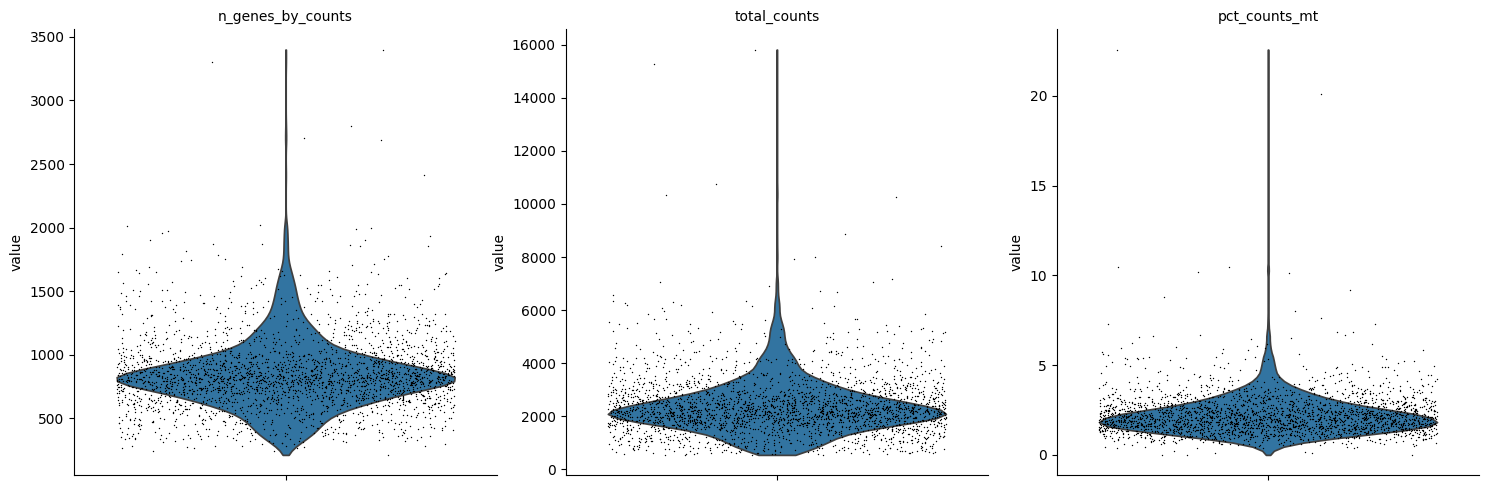

In [7]:
# Generate violin plots to visualize the distributions
sc.pl.violin(adata, ['n_genes_by_counts', 'total_counts', 'pct_counts_mt'],
             jitter=0.4, multi_panel=True)

1. n_genes_by_counts: The number of genes detected in each cell. Cells with very few genes are likely low-quality. Cells with a huge number might be doublets (two cells stuck together).

2. total_counts: The total number of RNA molecules detected per cell. Similar to n_genes_by_counts.

3. pct_counts_mt: The percentage of counts from mitochondrial genes. High percentages often indicate damaged cells.

Cell 4: Apply Filters

Based on the plots above, we can see that most good-quality cells have < 2,500 genes and < 5% mitochondrial counts. Let's filter out the outliers.



In [8]:
print("Shape before filtering:", adata.shape)

# Filter cells based on the QC plots
adata = adata[adata.obs.n_genes_by_counts < 2500, :]
adata = adata[adata.obs.pct_counts_mt < 5, :]

print("Shape after filtering:", adata.shape)

Shape before filtering: (2700, 13714)
Shape after filtering: (2638, 13714)


Cell 5: Normalize and Log-Transform Data

We normalize the data to account for differences in sequencing depth between cells. Then we apply a logarithm transform (log1p) to make the data distribution more manageable for downstream analysis.

In [9]:
# Normalize each cell to a total count of 10,000
sc.pp.normalize_total(adata, target_sum=1e4)

# Logarithmize the data
sc.pp.log1p(adata)

print("✅ Data normalized and log-transformed.")

/usr/local/lib/python3.12/dist-packages/scanpy/preprocessing/_normalization.py:269: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)


✅ Data normalized and log-transformed.


Cell 6: Identify Highly Variable Genes (HVGs)

To focus our analysis on biologically meaningful patterns, we'll identify genes that are highly variable across cells. These are the genes most likely to distinguish different cell types.

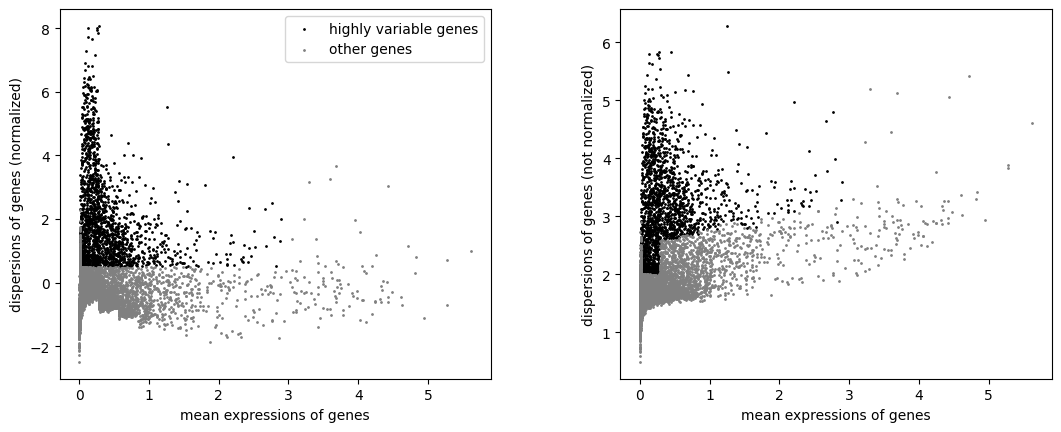

Identified 1838 highly variable genes.


In [10]:
# Identify highly variable genes
sc.pp.highly_variable_genes(adata, min_mean=0.0125, max_mean=3, min_disp=0.5)

# Plot the results
sc.pl.highly_variable_genes(adata)

print(f"Identified {adata.var.highly_variable.sum()} highly variable genes.")

Cell 7: Save the Processed Data

Finally, we'll save our clean, filtered, and normalized AnnData object. This way, we can easily load it in the next notebook without re-running all the preprocessing steps.

In [11]:
# Save the AnnData object to a file
adata.write('data/pbmc3k_processed.h5ad')

print("✅ Fully processed AnnData object saved to 'data/pbmc3k_processed.h5ad'")

✅ Fully processed AnnData object saved to 'data/pbmc3k_processed.h5ad'
